In [1]:
import numpy as np
import os
import json
import tensorflow as tf
import random
from vae.vae import CVAE
from model import make_model
from env import make_env

In [2]:
import matplotlib.pyplot as plt
import matplotlib.animation
%matplotlib inline
np.set_printoptions(precision=4, edgeitems=6, linewidth=100, suppress=True)

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="-1" # disable GPU

DATA_DIR = "results/eager/record"
model_path_name = "results/eager/tf_vae"

z_size=32

In [4]:
filelist = os.listdir(DATA_DIR)

In [5]:
obs = np.load(os.path.join(DATA_DIR, random.choice(filelist)))["obs"]
obs = obs.astype(np.float32)/255.0

In [6]:
obs.shape

(1000, 64, 64, 3)

In [7]:
frame = random.choice(obs).reshape(1, 64, 64, 3)

In [8]:
vae = CVAE(z_size=z_size,
              batch_size=1)

vae.set_weights(tf.keras.models.load_model(model_path_name, compile=False).get_weights())

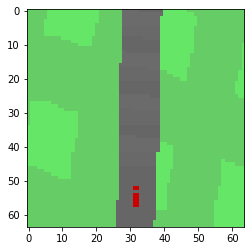

In [9]:
%matplotlib inline
# show recorded frame that will be fed into the input of VAE
plt.imshow(frame[0])
plt.show()

In [10]:
batch_z = vae.encode(frame)
print(batch_z[0]) # print out sampled z
reconstruct = vae.decode(batch_z)

tf.Tensor(
[ 1.7447  1.1366 -0.45   -0.6888 -0.8831  0.2722 -0.9381  1.6644 -1.0165 -1.5253  1.2342 -0.1869
  0.5746  1.0183 -0.7495  0.2416  1.3823  0.036  -1.1372  1.5922  0.2715 -0.8741  1.3412 -1.2828
  0.7058  1.3104 -0.7209  0.419  -0.0039 -0.8717 -0.5465 -0.544 ], shape=(32,), dtype=float32)


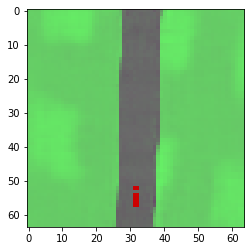

In [11]:
%matplotlib inline
# show reconstruction
plt.imshow(reconstruct[0])
plt.show()

## Dream Samples

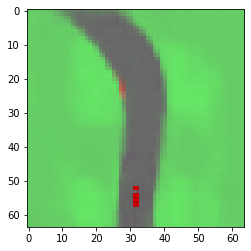

In [12]:
%matplotlib inline
batch_z = tf.random.normal((1, 32)).numpy()
reconstruct = vae.decode(batch_z)
# show reconstruction
plt.imshow(reconstruct[0])
plt.show()

# Simulate and Store for Animation

In [13]:
def sim(c, env, vae, is_true_env=False):
    o = env.reset()
    r_list = []
    total_r_list = []
    if is_true_env:
        o, reconstruct = o
    else:
        z = np.expand_dims(o[:32], axis=0)
        reconstruct = vae.decode(z)
    decoded_frames = [tf.squeeze(reconstruct)]
    for _ in range(1000): # episode length is a thousand
        a = c.get_action(o)
        o, r, _, _ = env.step(a)
        r_list.append(r)
        total_r_list.append(sum(r_list))
        if is_true_env:
            env.render('rgb_array')
            o, reconstruct = o
        else:
            z = np.expand_dims(o[:32], axis=0)
            reconstruct = vae.decode(z)
        decoded_frames.append(tf.squeeze(reconstruct))
    return decoded_frames, r_list, total_r_list

## Driving in true environment
visualize what the agent sees when driving in the true environment

In [14]:
c = make_model()
c.load_model('results/eager/log/carracing.cma.16.72.json')
true_env = make_env(with_obs=True)
true_episode, true_r, true_total_r = sim(c, true_env, vae, is_true_env=True)
true_env.close()

loading file results/eager/log/carracing.cma.16.72.json
Track generation: 1259..1578 -> 319-tiles track

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



<IPython.core.display.Javascript object>


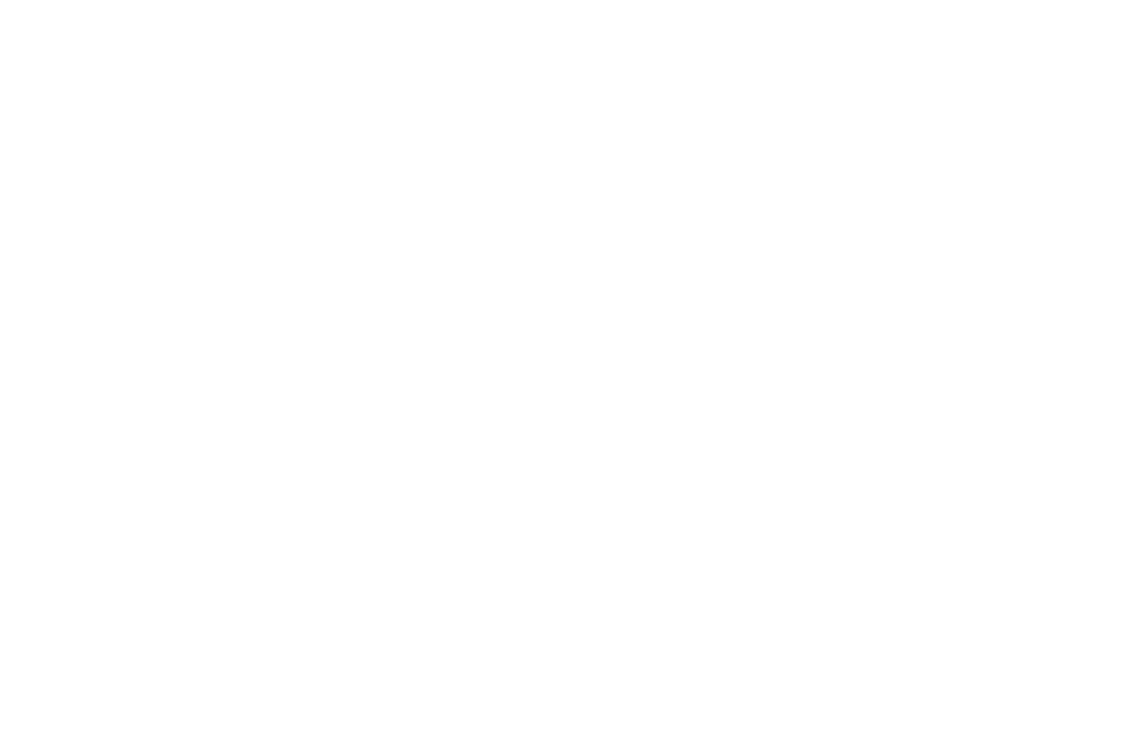

<IPython.core.display.Javascript object>


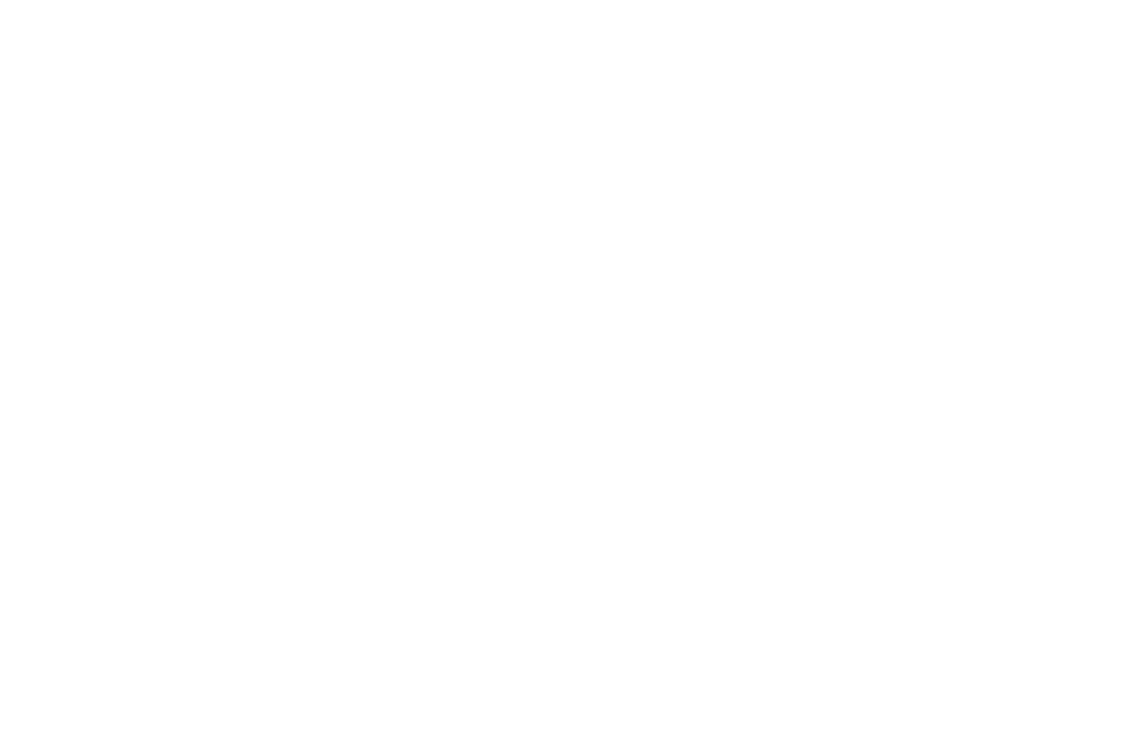

Traceback (most recent call last):
  File "/opt/miniconda3/envs/drwm/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 216, in process
    func(*args, **kwargs)
  File "/opt/miniconda3/envs/drwm/lib/python3.6/site-packages/matplotlib/animation.py", line 1465, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


In [15]:
%matplotlib notebook
# stupid jupyter bug, just keep copy pasting until it works
%matplotlib notebook 

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation

f = plt.figure()
ax = f.gca()

image = plt.imshow(true_episode[0].numpy(), interpolation='None', animated=True)

def function_for_animation(frame_index):
    image.set_data(true_episode[frame_index+1].numpy())
    ax.set_title('frame: {}, r: {:.2f}, total reward: {:.2f}'.format(frame_index, true_r[frame_index+1], true_total_r[frame_index+1]))
    return image,

ani = matplotlib.animation.FuncAnimation(f, function_for_animation, interval=40, frames=1000, blit=True)


## Return Plot for Controller

In [16]:
eager_filepath = os.path.join('results/eager/log', 'carracing.cma.16.72.hist.json')
og_filepath = os.path.join('results/og/log', 'carracing.cma.16.64.hist.json')
with open(eager_filepath, 'r') as f:
  eager_data = json.load(f)
with open(og_filepath, 'r') as f:
  og_data = json.load(f)

eager_data = np.array(eager_data)
comparison_len = eager_data.shape[0]
og_data = np.array(og_data)[:comparison_len]

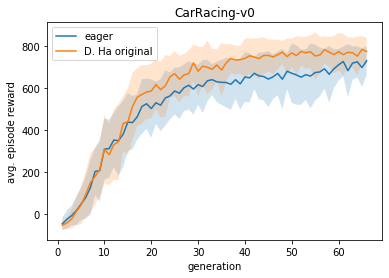

In [17]:
%matplotlib inline

x = eager_data[:, 0]
eager_ret = eager_data[:, 2]
eager_std = eager_data[:, 5]
og_ret = og_data[:, 2]
og_std = og_data[:, 5]

plt.figure()
plt.plot(x, eager_ret)
plt.fill_between(x, eager_ret-eager_std, eager_ret+eager_std, alpha=0.2)
plt.plot(og_data[:, 0], og_data[:, 2])
plt.fill_between(x, og_ret-og_std, og_ret+og_std, alpha=0.2)
plt.title('CarRacing-v0')
plt.ylabel('avg. episode reward')
plt.xlabel('generation')
plt.legend(['eager', 'D. Ha original'])

## Number of Tiles Distribution

In [11]:
import gym
from collections import Counter

e = gym.make('CarRacing-v0')
tile_counts = []
for i in range(10000):
    e.reset()
    tile_counts.append(len(e.env.track))
    if i % 10 == 0:
        print(i, '/10000')
        c = Counter(tile_counts)
        print(c.items())

Track generation: 1223..1533 -> 310-tiles track
0 /10000
dict_items([(309, 1)])
Track generation: 1079..1353 -> 274-tiles track
Track generation: 1321..1655 -> 334-tiles track
Track generation: 1091..1368 -> 277-tiles track
Track generation: 1147..1441 -> 294-tiles track
retry to generate track (normal if there are not many of this messages)
Track generation: 1108..1389 -> 281-tiles track
Track generation: 1087..1363 -> 276-tiles track
Track generation: 1237..1550 -> 313-tiles track
Track generation: 1106..1387 -> 281-tiles track
Track generation: 1240..1554 -> 314-tiles track
Track generation: 1191..1495 -> 304-tiles track
retry to generate track (normal if there are not many of this messages)
Track generation: 1083..1358 -> 275-tiles track
Track generation: 1136..1424 -> 288-tiles track
10 /10000
dict_items([(309, 1), (273, 1), (333, 1), (276, 1), (280, 2), (275, 1), (312, 1), (313, 1), (274, 1), (287, 1)])
Track generation: 1240..1554 -> 314-tiles track
Track generation: 1310..1642 

KeyboardInterrupt: 

<BarContainer object of 156 artists>

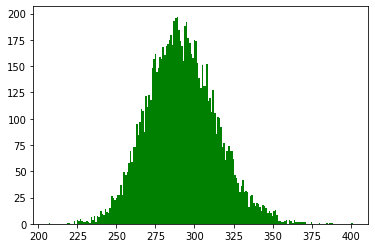

In [10]:
from operator import itemgetter
d = list(c.items())
d.sort(key = itemgetter(0))
d = np.array(d)
width=1.0
plt.bar(d[:, 0], d[:, 1], width, color='g')

In [28]:
np.amax(d, axis=0)
print('mean: {} std: {} min: {} max: {}'.format(np.mean(times), np.std(times), np.min(times), np.max(times)))
print(times)

mean: 1.9293528756933087 std: 2.1214294475594384 min: 0.02692890167236328 max: 19.358407735824585
[1.3425350189208984, 2.158026933670044, 2.661137104034424, 0.6963527202606201, 0.6812679767608643, 0.36623501777648926, 0.09747195243835449, 1.3374691009521484, 2.0233681201934814, 0.43950986862182617, 1.251277208328247, 0.8719990253448486, 3.541461229324341, 1.8668241500854492, 2.949885129928589, 5.186642169952393, 1.9445481300354004, 0.39512085914611816, 3.256282091140747, 1.2959280014038086, 2.079533100128174, 0.9474818706512451, 0.8575942516326904, 1.567885160446167, 0.20979094505310059, 1.3557260036468506, 1.4858691692352295, 1.4115440845489502, 0.21104001998901367, 3.35718035697937, 1.7683351039886475, 0.4323740005493164, 0.653278112411499, 5.1109819412231445, 2.658003807067871, 0.14002394676208496, 0.3289628028869629, 0.8127217292785645, 0.23626208305358887, 1.3338038921356201, 0.02692890167236328, 0.8088607788085938, 1.6889421939849854, 0.587698221206665, 0.1291501522064209, 0.6484

In [21]:
from time import time
e = gym.make('CarRacing-v0')
targ_n = 289 # reset until we hit the target
times = []
for i in range(1000):
    start = time()
    e.reset()
    n_tiles = len(e.env.track)
    while n_tiles != targ_n:
        e.reset()
        n_tiles = len(e.env.track)
    end = time()
    times.append(end-start)
    if i % 10 == 0:
        print(np.mean(times))

Track generation: 1096..1379 -> 283-tiles track
Track generation: 1275..1598 -> 323-tiles track
Track generation: 1128..1414 -> 286-tiles track
Track generation: 1252..1569 -> 317-tiles track
Track generation: 1147..1438 -> 291-tiles track
Track generation: 1235..1548 -> 313-tiles track
Track generation: 1231..1543 -> 312-tiles track
Track generation: 1228..1546 -> 318-tiles track
Track generation: 1253..1570 -> 317-tiles track
Track generation: 1250..1567 -> 317-tiles track
Track generation: 1153..1451 -> 298-tiles track
Track generation: 1063..1339 -> 276-tiles track
Track generation: 1236..1549 -> 313-tiles track
Track generation: 1180..1479 -> 299-tiles track
Track generation: 1164..1459 -> 295-tiles track
Track generation: 1099..1378 -> 279-tiles track
Track generation: 1119..1407 -> 288-tiles track
retry to generate track (normal if there are not many of this messages)
Track generation: 1179..1478 -> 299-tiles track
Track generation: 1140..1429 -> 289-tiles track
Track generation

KeyboardInterrupt: 